In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.metrics import MeanAbsoluteError, MeanSquaredError
import matplotlib.pyplot as plt
from datetime import datetime

In [11]:
# Step 1: Load data from Yahoo Finance
stock_symbol = 'AAPL'  # Apple as an example
data = yf.download(stock_symbol, start='2010-01-01', end=datetime.now().strftime('%Y-%m-%d'))

[*********************100%%**********************]  1 of 1 completed


In [12]:
# Step 2: Preprocess Data
data = data[['Close']]  # Focus on 'Close' prices
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [13]:
# Define training and testing data
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [14]:
# Step 3: Create sequences for LSTM
def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

In [15]:
seq_length = 60  # Use 60 previous days to predict the next
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [16]:
# Step 4: Build the LSTM Model
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=25),
    Dense(units=1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 15s 131ms/step - loss: 0.0124 - val_loss: 8.7780e-04
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - loss: 6.1194e-04 - val_loss: 0.0012
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - loss: 4.9188e-04 - val_loss: 9.2087e-04
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - loss: 4.5944e-04 - val_loss: 0.0053
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - loss: 5.3963e-04 - val_loss: 0.0011
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - loss: 3.1184e-04 - val_loss: 0.0021
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - loss: 3.0420e-04 - val_loss: 8.4851e-04
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - loss: 2.9658e-04 - val_loss: 7.6086e-04
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - loss: 3.6080e-04 - val_loss: 0.0014
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - loss: 3.4640e-04 - val_loss: 9.0143e-04


In [8]:
# Step 5: Predict on test data and visualize
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)
actual_prices = scaler.inverse_transform(test_data[seq_length:])

38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step


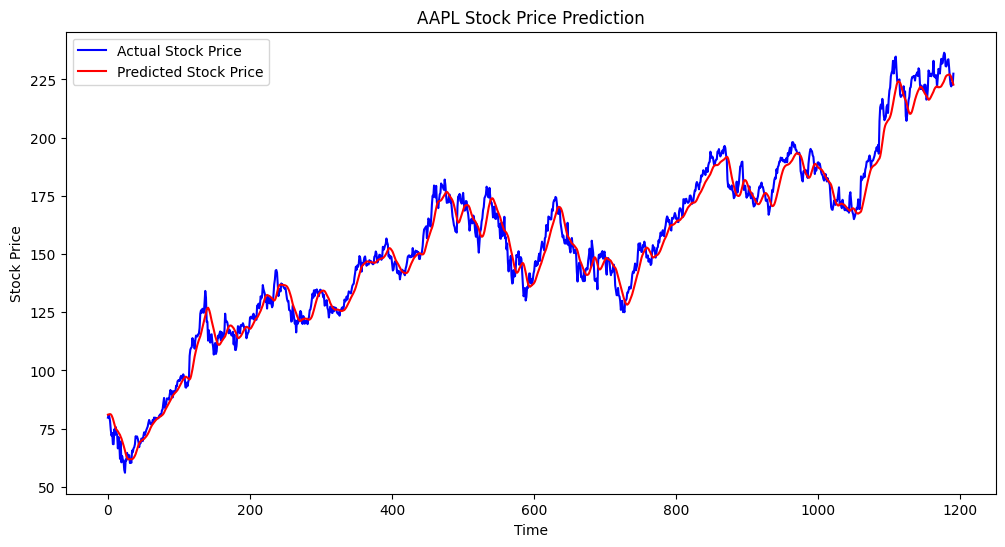

Mean Absolute Error (MAE): 4.554315567016602
Mean Squared Error (MSE): 32.91248321533203


In [9]:
# Plot actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(actual_prices, color='blue', label='Actual Stock Price')
plt.plot(predicted_prices, color='red', label='Predicted Stock Price')
plt.title(f'{stock_symbol} Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Step 6: Accuracy Metrics
mse = MeanSquaredError()
mae = MeanAbsoluteError()
mse.update_state(actual_prices, predicted_prices)
mae.update_state(actual_prices, predicted_prices)

print(f"Mean Absolute Error (MAE): {mae.result().numpy()}")
print(f"Mean Squared Error (MSE): {mse.result().numpy()}")

In [10]:
# Step 7: Predict stock price for a specific future date
input_date = input("Enter a future date (YYYY-MM-DD): ")
target_date = datetime.strptime(input_date, '%Y-%m-%d')

# Calculate days to predict from the last available date in the data
last_date = data.index[-1].to_pydatetime().replace(tzinfo=None)  # Convert to timezone-naive datetime
days_to_predict = (target_date - last_date).days

if days_to_predict <= 0:
    print("The entered date is not in the future. Please enter a future date.")
else:
    # Generate predictions up to the target date
    last_sequence = test_data[-seq_length:]
    predicted_future_prices = []

    for _ in range(days_to_predict):
        prediction = model.predict(last_sequence.reshape(1, seq_length, 1))
        predicted_future_prices.append(prediction[0, 0])
        last_sequence = np.append(last_sequence[1:], prediction, axis=0)

    predicted_future_prices = scaler.inverse_transform(np.array(predicted_future_prices).reshape(-1, 1))

    # Print the predicted stock price for the specific future date
    predicted_price_on_target_date = predicted_future_prices[-1][0]
    print(f"Predicted Stock Price for {input_date}: ${predicted_price_on_target_date:.2f}")

Enter a future date (YYYY-MM-DD):  2025-01-23


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━

[*********************100%***********************]  1 of 1 completed
D:\Users\Ghanavi Arun\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 19s 123ms/step - loss: 0.0014 - val_loss: 7.6564e-04
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 104ms/step - loss: 8.0464e-05 - val_loss: 0.0017
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - loss: 6.5108e-05 - val_loss: 7.5884e-04
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - loss: 4.7023e-05 - val_loss: 6.3693e-04
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 103ms/step - loss: 5.0009e-05 - val_loss: 6.4244e-04
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 100ms/step - loss: 6.1453e-05 - val_loss: 0.0011
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 106ms/step - loss: 4.8697e-05 - val_loss: 9.5751e-04
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 105ms/step - loss: 4.1586e-05 - val_loss: 5.9112e-04
Epoch 9/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 108ms/step - loss: 4.7191e-05 - val_loss: 6.0548e-04
Epoch 10/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 8s 108ms/step - loss: 4.6014e-05 - val_loss: 6.8300e-04
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step


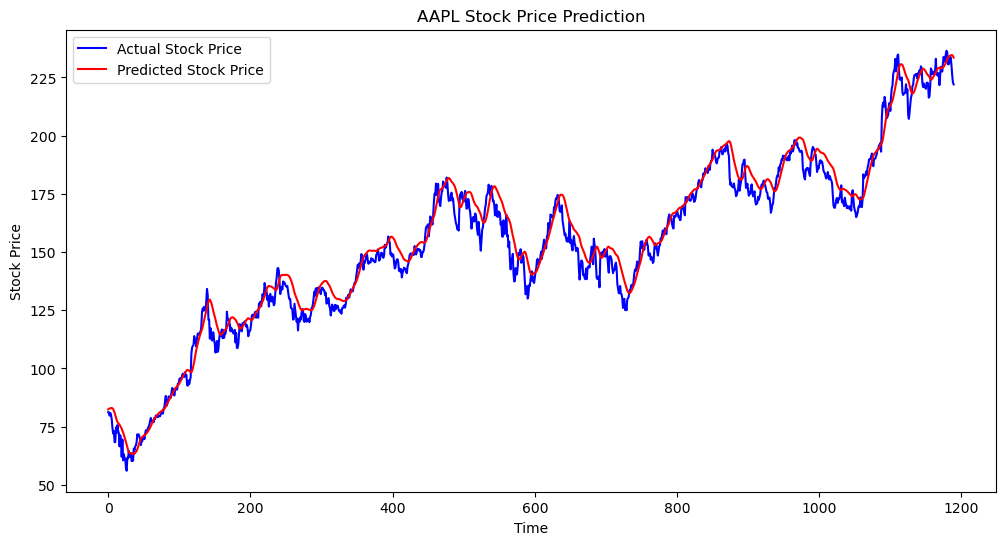

Mean Absolute Error (MAE): 4.819299221038818
Mean Squared Error (MSE): 38.1196174621582
Enter a future date (YYYY-MM-DD): 2025-12-25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90m

In [1]:
# import yfinance as yf
# import numpy as np
# import pandas as pd
# from sklearn.preprocessing import MinMaxScaler
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, Dropout
# from tensorflow.keras.metrics import MeanAbsoluteError, MeanSquaredError
# import matplotlib.pyplot as plt
# from datetime import datetime

# Step 1: Load data from Yahoo Finance
stock_symbol = 'AAPL'  # Apple as an example
data = yf.download(stock_symbol, start='2000-01-01', end=datetime.now().strftime('%Y-%m-%d'))

# Step 2: Preprocess Data
data = data[['Close']]  # Focus on 'Close' prices
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Define training and testing data
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Step 3: Create sequences for LSTM
def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

seq_length = 60  # Use 60 previous days to predict the next
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Step 4: Build the LSTM Model
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=25),
    Dense(units=1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

# Step 5: Predict on test data and visualize
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)
actual_prices = scaler.inverse_transform(test_data[seq_length:])

# Plot actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(actual_prices, color='blue', label='Actual Stock Price')
plt.plot(predicted_prices, color='red', label='Predicted Stock Price')
plt.title(f'{stock_symbol} Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Step 6: Accuracy Metrics
mse = MeanSquaredError()
mae = MeanAbsoluteError()
mse.update_state(actual_prices, predicted_prices)
mae.update_state(actual_prices, predicted_prices)

print(f"Mean Absolute Error (MAE): {mae.result().numpy()}")
print(f"Mean Squared Error (MSE): {mse.result().numpy()}")

# Step 7: Predict stock price for a specific future date
input_date = input("Enter a future date (YYYY-MM-DD): ")
target_date = datetime.strptime(input_date, '%Y-%m-%d')

# Calculate days to predict from the last available date in the data
last_date = data.index[-1].to_pydatetime().replace(tzinfo=None)  # Convert to timezone-naive datetime
days_to_predict = (target_date - last_date).days

if days_to_predict <= 0:
    print("The entered date is not in the future. Please enter a future date.")
else:
    # Generate predictions up to the target date
    last_sequence = test_data[-seq_length:]
    predicted_future_prices = []

    for _ in range(days_to_predict):
        prediction = model.predict(last_sequence.reshape(1, seq_length, 1))
        predicted_future_prices.append(prediction[0, 0])
        last_sequence = np.append(last_sequence[1:], prediction, axis=0)

    predicted_future_prices = scaler.inverse_transform(np.array(predicted_future_prices).reshape(-1, 1))

    # Print the predicted stock price for the specific future date
    predicted_price_on_target_date = predicted_future_prices[-1][0]
    print(f"Predicted Stock Price for {input_date}: ${predicted_price_on_target_date:.2f}")
